## Fine-tuning

Here the data preparation and data processing is implemented. Then, the training and validation of the model is performed, using a data augmentation pipeline, which includes spatial and intensity-based techniques. However, a pre-trained model is loaded and just a few layers are fine-tuned. The GOAL is to re-train a model to segment the left ventricle and the myocardium using LGE-MRI images from a new dataset. 

##### Import libraries:

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.backends.backend_pdf import PdfPages
import os 
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.augmentations.transforms import HorizontalFlip, VerticalFlip, Rotate, RandomScale, GaussNoise, RandomGamma, RandomBrightnessContrast, Resize
import re
import cv2
from skimage import measure, exposure
import torchvision

##### Data preparation: 

In [2]:
#Function to load nifti files

def load_nii(path): 
    data = nib.load(path)
    return data.get_fdata()

Define paths to the training and validation folders to access LGE-MRI volumes and the corresponding masks: 

In [3]:
data_path_train = '/home/carla/Desktop/euCanSHare/Datasets/training/training_STPAU'
listdir_train = os.listdir(data_path_train)
df_train = pd.DataFrame({'patient': listdir_train})
df_train = df_train[:1] #number of samples used to fine-tune

In [4]:
imgs_path_train = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE.nii.gz' for d in df_train.patient]
masks_path_train = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE_gt.nii.gz' for d in df_train.patient]

In [5]:
data_path_val = '/home/carla/Desktop/euCanSHare/Datasets/validation/validation_STPAU'
listdir_val = os.listdir(data_path_val)
df_val = pd.DataFrame({'patient': listdir_val})
df_val = df_val[:1] #number of samples used to fine-tune

In [6]:
imgs_path_val = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE.nii.gz' for d in df_val.patient]
masks_path_val = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE_gt.nii.gz' for d in df_val.patient]

Read data and save each slice as .npy file so that it is faster to load during training:

In [7]:
#Function to load the data volumes and masks to save each slice in .npy format and in separate folders

def generate_slices(data_path, df_path, imgs_path, masks_path): 
    
    for ix, p in enumerate (tqdm(df_path.patient)): 
        if "VH" in imgs_path[ix] or "STPAU" in imgs_path[ix]:
            v_lge = load_nii('{}/{}'.format(data_path, imgs_path[ix]))[:,:,:,0]
            v_gt = load_nii('{}/{}'.format(data_path, masks_path[ix]))[:,:,:,0]
        else: 
            v_lge = load_nii('{}/{}'.format(data_path, imgs_path[ix]))
            v_gt = load_nii('{}/{}'.format(data_path, masks_path[ix]))
            
        img_folder = '{}/{}/img_slices'.format(data_path, p)
        if not os.path.exists(img_folder): 
            os.mkdir(img_folder) #create folder for each subject to save image slices 
        channels = v_lge.shape[2]
        for c in range (channels):
            img = v_lge[:, :, c]
            if img.shape[0] < img.shape[1]: 
                img = np.rot90(img)  
            np.save('{}/img_{}'.format(img_folder,c) + '.npy', img)

        mask_folder = '{}/{}/gt_slices'.format(data_path, p)
        if not os.path.exists(mask_folder): 
            os.mkdir(mask_folder) #create folder for each subject to save segmentation slices
        channels = v_gt.shape[2]
        for c in range (channels):
            gt = np.array(v_gt[:, :, c], dtype=np.uint8)
            if gt.shape[0] < gt.shape[1]:
                gt = np.rot90(gt)
            np.save('{}/gt_{}'.format(mask_folder,c) + '.npy', gt)

Load volumes and masks and save each slice as .npy file in separate folders:

In [8]:
generate_slices(data_path_train, df_train, imgs_path_train, masks_path_train)

100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


In [9]:
generate_slices(data_path_val, df_val, imgs_path_val, masks_path_val)

100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


In [10]:
len(df_train), len(df_val) #number of training and validation subjects

(1, 1)

Define paths to call folder with .npy slices

In [11]:
img_path_train = [d + '/img_slices' for d in df_train.patient]
gt_path_train = [d + '/gt_slices' for d in df_train.patient]

img_path_val = [d + '/img_slices' for d in df_val.patient]
gt_path_val = [d + '/gt_slices' for d in df_val.patient]

Visualisation of images and groundtruths of the training data to make sure that the data is loaded properly: 

3
(288, 288) float64 682.0 0.0
(288, 288) uint8 2 0


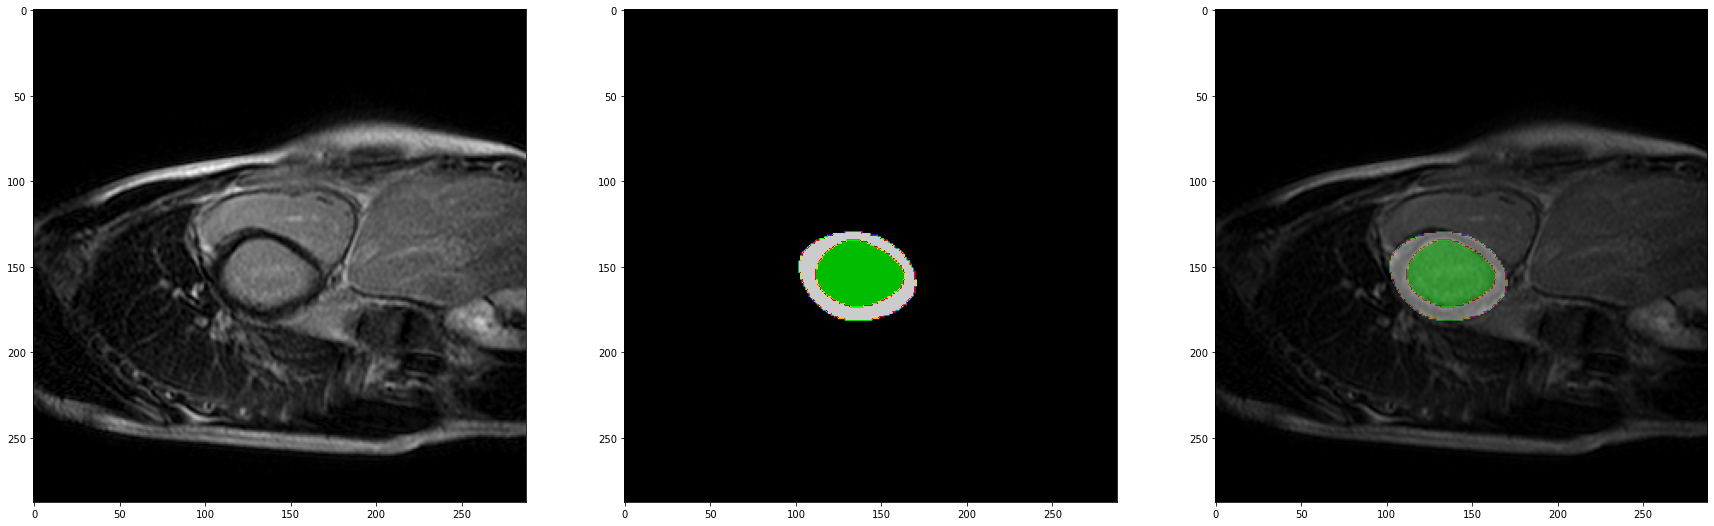

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30,10))
ix = random.randint(0, len(gt_path_train)-1)
channel = random.randint(0, 5)
img = np.load('{}/{}/img_{}.npy'.format(data_path_train, img_path_train[ix], channel))
gt = np.load('{}/{}/gt_{}.npy'.format(data_path_train, gt_path_train[ix], channel))
ax1.imshow(img[:,:], cmap='gist_gray')
ax2.imshow(gt[:,:], cmap='nipy_spectral')
ax3.imshow(img[:,:], cmap='gist_gray')
ax3.imshow(gt[:,:], alpha=0.5, cmap='nipy_spectral')

print(channel)
print(img.shape, img.dtype, img.max(), img.min())
print(gt.shape, gt.dtype, gt.max(), gt.min())

In [13]:
#Function to obtain center coordinates

def get_center_crop_coords(width, height, crop_width, crop_height):
    y1 = (width - crop_width) // 2
    y2 = y1 + crop_width
    x1 = (height - crop_height) // 2
    x2 = x1 + crop_height
    return x1, y1, x2, y2

#Function to implement a center cropping

def center_crop(img, gt, crop_width, crop_height):
    width, height = img.shape[:2]
    case = 0
    
    if width <= 256 and height >= 256: #crop height
        crop = 256
        x1 = (height - crop) // 2
        x2 = x1 + crop
        y1 = 0
        y2 = width
        case = 1
    
    if width >= 256 and height <= 256: #crop width
        crop = 256
        y1 = (width - crop) // 2
        y2 = y1 + crop 
        x1 = 0
        x2 = height
        case = 2
        
    if width >= 256 and height >= 256: #crop both 
        x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)
        case = 3
    
    if width <= 256 and height <= 256: #crop none of them
        case = 4

    sum_MYO_LV = gt.sum() #make sure the gt is not removed
    count = 0
    while True:
        if case == 1: 
            y1 = 0
            y2 = width
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 2: 
            x1 = 0
            x2 = height 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 3: 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        else: 
            img_cropped = img
            gt_cropped = gt
        
        if gt_cropped.sum() == sum_MYO_LV: 
            #gt is not removed
            break
        
        #gt is removed
        
        #go for a center cropping 
        if count == 0:   
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)
        #else:
        if count > 0 and count < 30: #shorten height 
            x1 += 10
            x2 -= 10
        if count == 30: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)
        
        if count > 30 and count < 60: #lengthen height 
            x2 += 10
            x1 -= 10
        if count == 60: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 60 and count < 90: #shorten width 
            y1 += 10
            y2 -= 10
        if count == 90: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height) 
        
        if count > 90 and count < 120: #lengthen width 
            y2 += 10
            y1 -= 10
        if count == 120: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 120 and count < 150: #lengthen width and height
            y2 += 10
            y1 -= 10
            x2 += 10
            x1 -= 10
        if count == 150: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 150 and count < 180: #legthen width and shorten height
            y2 += 10
            y1 -= 10
            x2 -= 10
            x1 += 10
        if count == 180: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 180 and count < 210: #shorten width and height
            y2 -= 10
            y1 += 10
            x2 -= 10
            x1 += 10
        if count == 210: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 210: #shorten width and lengthen height
            y2 -= 10
            y1 += 10
            x2 += 10
            x1 -= 10
        count += 1
    
    if img_cropped.shape[0] != 256 or img_cropped.shape[1] != 256: #if the size is not the desired one resize
        resize = Resize(256, 256)
        img_cropped = resize(image=img_cropped)['image']
        gt_cropped = resize(image=gt_cropped)['image']
               
    return img_cropped, gt_cropped

In [14]:
#Function to obtain random coordinates

def get_random_crop_coords(width, height, crop_width, crop_height, h_start, w_start):
    y1 = int((width - crop_width) * h_start)
    y2 = y1 + crop_width
    x1 = int((height - crop_height) * w_start)
    x2 = x1 + crop_height
    return x1, y1, x2, y2


#Function to implement a random cropping

def random_crop(img, gt, crop_width, crop_height):
    width, height = img.shape[:2]
    case = 0
    
    if width <= 256 and height >= 256: #crop height
        crop = 256
        x1 = (height - crop) // 2
        x2 = x1 + crop
        y1 = 0
        y2 = width
        case = 1
    
    if width >= 256 and height <= 256: #crop width
        crop = 256
        y1 = (width - crop) // 2
        y2 = y1 + crop 
        x1 = 0
        x2 = height
        case = 2
        
    if width >= 256 and height >= 256: #crop both 
        h_start = random.random()
        w_start = random.random()
        x1, y1, x2, y2 = get_random_crop_coords(width, height, crop_width, crop_height, h_start, w_start)
        case = 3
    
    if width <= 256 and height <= 256: #crop none of them
        case = 4

    sum_MYO_LV = gt.sum() #make sure the gt is not removed
    count = 0
    while True:
        if case == 1: 
            y1 = 0
            y2 = width
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 2: 
            x1 = 0
            x2 = height 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 3: 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        else: 
            img_cropped = img
            gt_cropped = gt
        
        if gt_cropped.sum() == sum_MYO_LV: 
            #gt is not removed
            break
        
        #gt is removed
        if count<15: #try random coordinates 14 times more    
            h_start = random.random()
            w_start = random.random()
            x1, y1, x2, y2 = get_random_crop_coords(width, height, crop_width, crop_height, h_start, w_start)     
        
        #otherwise go for a center cropping 
        if count == 15:   
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)
        #else:
        if count > 15 and count < 45: #shorten height 
            x1 += 10
            x2 -= 10
        if count == 45: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)
        
        if count > 45 and count < 75: #lengthen height 
            x2 += 10
            x1 -= 10
        if count == 75: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 75 and count < 105: #shorten width 
            y1 += 10
            y2 -= 10
        if count == 105: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height) 
        
        if count > 105 and count < 135: #lengthen width 
            y2 += 10
            y1 -= 10
        if count == 135: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 135 and count < 165: #lengthen width and height
            y2 += 10
            y1 -= 10
            x2 += 10
            x1 -= 10
        if count == 165: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 165 and count < 195: #legthen width and shorten height
            y2 += 10
            y1 -= 10
            x2 -= 10
            x1 += 10
        if count == 195: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 195 and count < 225: #shorten width and height
            y2 -= 10
            y1 += 10
            x2 -= 10
            x1 += 10
        if count == 225: 
            x1, y1, x2, y2 = get_center_crop_coords(width, height, crop_width, crop_height)            
        
        if count > 225: #shorten width and lengthen height
            y2 -= 10
            y1 += 10
            x2 += 10
            x1 -= 10
        count += 1
    
    if img_cropped.shape[0] != 256 or img_cropped.shape[1] != 256: #if the size is not the desired one resize
        resize = Resize(256, 256)
        img_cropped = resize(image=img_cropped)['image']
        gt_cropped = resize(image=gt_cropped)['image']
               
    return img_cropped, gt_cropped

In [15]:
#Function to apply inverse gamma

def gamma_inverse(img, gamma_limit):
    gamma = random.randint(gamma_limit[0], gamma_limit[1]) / 100.0
    if img.dtype == np.uint8:
        table = (np.arange(0, 256.0 / 255, 1.0 / 255) ** (1/gamma)) * 255
        img = cv2.LUT(img, table.astype(np.uint8))
    else:
        img = np.power(img, gamma)

    return img

In [16]:
#Funtion to keep only the largest connected components in the mask  

def keep_largest_connected_components(mask):
    '''
    Keeps only the largest connected components of each label for a segmentation mask.
    '''

    out_img = np.zeros(mask.shape, dtype=np.uint8)

    for struc_id in [1, 2, 3]:

        binary_img = mask == struc_id
        blobs = measure.label(binary_img, connectivity=1)

        props = measure.regionprops(blobs)

        if not props:
            continue

        area = [ele.area for ele in props]
        largest_blob_ind = np.argmax(area)
        largest_blob_label = props[largest_blob_ind].label

        out_img[blobs == largest_blob_label] = struc_id

    return out_img

Create the DataLoader:

In [17]:
class MRIDataset(Dataset): 
    def __init__(self, data_path, img_path, gt_path, augmentation=True, num_classes=3):
        self.data_path = data_path
        self.img_path = img_path
        self.gt_path = gt_path
        self.augmentation = augmentation
        self.num_classes = num_classes
    def __len__(self):
        return len(self.img_path) 
    def __getitem__(self, ix): #slice by slice 
                
        img = np.load('{}/{}'.format(self.data_path, self.img_path[ix]))
                
        gt = np.load('{}/{}'.format(self.data_path, self.gt_path[ix]))
                                         
        if "MSCMR" in self.img_path[ix]: 
            self.num_classes = 4 
        if "EMIDEC" in self.img_path[ix]:
            mask = img>0 #remove black background
            img = img[np.ix_(mask.any(1),mask.any(0))]
            gt = gt[np.ix_(mask.any(1),mask.any(0))]
            self.num_classes = 5
        if "VH" in self.img_path[ix]: 
            mask = img>0 #remove black background
            img = img[np.ix_(mask.any(1),mask.any(0))]
            gt = gt[np.ix_(mask.any(1),mask.any(0))]
        
        if self.augmentation: #spatial-based data augmentation
                
            horizontal_flip = HorizontalFlip(p=0.2)
            vertical_flip = VerticalFlip(p=0.2)
            rotation = Rotate(p=0.2, limit=[-30, 30])
            rescale = RandomScale(scale_limit=[0.75, 1.18], p=0.2) 
            
            data = horizontal_flip(image=img, mask=gt) #horizational flip
            img = data['image']
            gt = data['mask']

            data = vertical_flip(image=img, mask=gt) #vertical flip
            img = data['image']
            gt = data['mask']
            
            data = rotation(image=img, mask=gt) #rotation
            img = data['image']
            gt = data['mask'] 

            data = rescale(image=img, mask=gt) #rescaling
            img = data['image']
            gt = data['mask']
            
            [img, gt] = random_crop(img, gt, 256, 256) #cropping
        
        else: #baseline
            [img, gt] = center_crop(img, gt, 256, 256) #cropping
            
        img = np.array((img-np.min(img))/(np.max(img)-np.min(img)), dtype=np.float32) #min-max normalisation
               
        if self.augmentation: #intensity-based data augmentation
        
            gaussian = GaussNoise(var_limit=(0, 0.001), p=0.2)
            gamma = RandomGamma(gamma_limit=(70, 150), p=0.2)
            brightness = RandomBrightnessContrast(brightness_limit=(0.5), contrast_limit=0, p=0.2)
            contrast = RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0.5), p=0.2)
            
            img = img.astype('float32')
            if random.uniform(0,1) < 0.2: 
                img = cv2.bilateralFilter(img,7,75,75) #bilateral filtering
            
            img = gaussian(image=img)['image'] #gaussian
            
            img = gamma(image=img)['image'] #gamma
            
            if random.uniform(0,1) < 0.2:
                img = gamma_inverse(img=img, gamma_limit=(70, 150)) #inverse gamma
            
            img = brightness(image=img)['image'] #brightness
            
            img = contrast(image=img)['image'] #contrast
                    
        gt = (np.arange(self.num_classes) == gt[...,None]).astype(int) #create binary gt
        
        if "MSCMR" in self.img_path[ix]: #remove noise from the resize of the groundtruth
            gt[:,:,3] = keep_largest_connected_components(gt[:,:,3])
        else:
            gt[:,:,1] = keep_largest_connected_components(gt[:,:,1])        
        
        #keep only 3 labels: BG (0), MYO(1) and LV(2)
        if "MSCMR" in self.img_path[ix]:
            gt[:, :, 0] += gt[:, :, 1] #0:BG
            gt[:, :, 1] = gt[:, :, 2] #1:MYO
            gt[:, :, 2] = gt[:, :, 3] #2:LV
            gt = gt[:, :, 0:3] 
            
        if "EMIDEC" in self.img_path[ix]:            
            gt[:,:,3] += gt[:,:,2] #1:MYO
            gt[:,:,3] += gt[:,:,4] #1:MYO
            gt[:,:,2] = gt[:,:,1] #2:LV
            gt[:,:,1] = gt[:,:,3] #1:MYO
            gt = gt [:,:,0:3]
            
        if "VH" in self.img_path[ix] or "STPAU" in self.img_path[ix]: 
            gt_ = np.zeros((gt.shape))
            gt_[:,:,0] = gt[:,:,0] #0:BG
            gt_[:,:,1] = gt[:,:,2] #1:MYO
            gt_[:,:,2] = gt[:,:,1] #2:LV
            gt = gt_
                 
        gt[:,:,0] = np.ones((gt.shape[0], gt.shape[1])) - gt[:, :, 1] - gt[:, :, 2]
                
        return torch.from_numpy(img).unsqueeze(0).float(), torch.from_numpy(gt.transpose((2,0,1))).float()

Define paths to call .npy slices:

In [18]:
#Training

img_train = []
gt_train = []
for patient in img_path_train:

    img_train += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_train, patient)))]

for patient in gt_path_train:

    gt_train += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_train, patient)))]

#Validation

img_val = []
gt_val = []
for patient in img_path_val:

    img_val += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_val, patient)))]

for patient in gt_path_val:

    gt_val += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_val, patient)))]

Define DataLoader for training and validation data:

In [19]:
dataset = {
    'train': MRIDataset(data_path_train, img_train, gt_train, augmentation=True),
    'val': MRIDataset(data_path_val, img_val, gt_val, augmentation=False), 
}

len(dataset['train']), len(dataset['val']) #number of samples

(20, 20)

Visualisation of images and groundtruths of the training data to make sure that the data is processed properly: 

torch.Size([1, 256, 256]) torch.float32 tensor(1.) tensor(0.)
torch.Size([3, 256, 256]) torch.float32 tensor(1.) tensor(0.) True


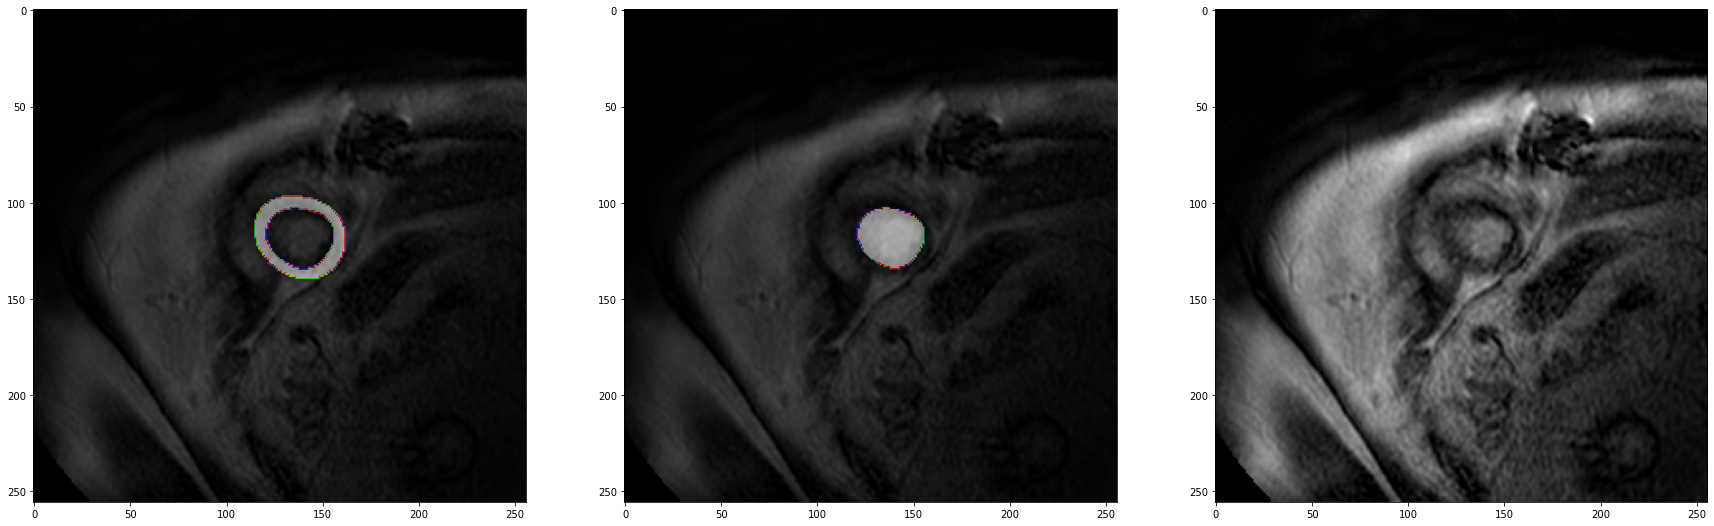

In [20]:
ds = dataset['val']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30,10))
ix = random.randint(0, len(ds)-1)
img, gt = ds[ix]
print(img.shape, img.dtype, img.max(), img.min())
print(gt.shape, gt.dtype, gt.max
      (), gt.min(), gt.sum().item() == gt.shape[1]*gt.shape[2])
_img = img.numpy().transpose((1,2,0))
ax1.imshow(_img[:, :, 0].squeeze(), cmap='gist_gray') 
ax2.imshow(_img[:, :, 0].squeeze(), cmap='gist_gray')
ax3.imshow(_img[:, :, 0].squeeze(), cmap='gist_gray')
_gt = gt.numpy().transpose((1,2,0))
ax1.imshow(_gt[:,:,1], alpha=0.6, cmap='nipy_spectral')
ax2.imshow(_gt[:,:,2], alpha=0.6, cmap='nipy_spectral')

Define batch size for each DataLoader:

In [21]:
bs = 16
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=bs, shuffle=True, num_workers=4),
    'val': DataLoader(dataset['val'], batch_size=1, shuffle=False, num_workers=4), 
}

##### Training implementation: 

Model:

In [22]:
class DoubleConvNN(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)     

class UpsampleNN(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(in_channels , out_channels, kernel_size=3, stride=2)
        self.conv = DoubleConvNN(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x) 

class nnUNet(nn.Module):
    def __init__(self, num_labels): 
        super().__init__()

        self.inconv = DoubleConvNN(1, 32)

        self.maxpool1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConvNN(32, 64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv2 = DoubleConvNN(64, 128)
        self.maxpool3 = nn.MaxPool2d(2)
        self.conv3 = DoubleConvNN(128, 256)
        self.maxpool4 = nn.MaxPool2d(2)
        self.conv4 = DoubleConvNN(256, 512)
        self.maxpool5 = nn.MaxPool2d(2)
        self.conv5 = DoubleConvNN(512, 1024)
        
        self.upsample1 = UpsampleNN(1024, 512)
        self.upsample2 = UpsampleNN(512, 256)
        self.upsample3 = UpsampleNN(256, 128)
        self.upsample4 = UpsampleNN(128, 64)
        self.upsample5 = UpsampleNN(64, 32)

        self.outconv = nn.Conv2d(32, num_labels, kernel_size=1)

        self.deep_conv1 = nn.Conv2d(512, num_labels, kernel_size=1)
        self.deep_conv2 = nn.Conv2d(256, num_labels, kernel_size=1)
        self.deep_conv3 = nn.Conv2d(128, num_labels, kernel_size=1)
        self.deep_conv4 = nn.Conv2d(64, num_labels, kernel_size=1)

        self.deep_deconv = nn.ConvTranspose2d(num_labels, num_labels, kernel_size=3, stride=2)

    def forward(self, x):
        x1 = self.inconv(x)

        x2 = self.maxpool1(x1)
        x2 = self.conv1(x2)
        x3 = self.maxpool2(x2)
        x3 = self.conv2(x3)
        x4 = self.maxpool3(x3)
        x4 = self.conv3(x4)
        x5 = self.maxpool4(x4)
        x5 = self.conv4(x5)
        x6 = self.maxpool5(x5)
        x6 = self.conv5(x6)

        x  = self.upsample1(x6, x5)
        x_ = self.deep_conv1(x)
        x1_deep = self.deep_deconv(x_)
        
        x = self.upsample2(x, x4)
        x_ = self.deep_conv2(x)
        diffY = x_.size()[2] - x1_deep.size()[2]
        diffX = x_.size()[3] - x1_deep.size()[3]
        x1_deep = F.pad(x1_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x_ = torch.add(x1_deep, x_)
        x2_deep = self.deep_deconv(x_)

        x = self.upsample3(x, x3)
        x_ = self.deep_conv3(x)
        diffY = x_.size()[2] - x2_deep.size()[2]
        diffX = x_.size()[3] - x2_deep.size()[3]
        x2_deep = F.pad(x2_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x_ = torch.add(x2_deep, x_)
        x3_deep = self.deep_deconv(x_)

        x = self.upsample4(x, x2)     
        x_ = self.deep_conv4(x)
        diffY = x_.size()[2] - x3_deep.size()[2]
        diffX = x_.size()[3] - x3_deep.size()[3]
        x3_deep = F.pad(x3_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x_ = torch.add(x3_deep, x_)
        x4_deep = self.deep_deconv(x_)

        x = self.upsample5(x, x1)

        x = self.outconv(x)

        diffY = x.size()[2] - x4_deep.size()[2]
        diffX = x.size()[3] - x4_deep.size()[3]
        x4_deep = F.pad(x4_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

        x = torch.add(x4_deep, x)
        return x

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nnUNet(num_labels=3)

model.load_state_dict(torch.load('../../Models/state_dict.pth')['model_state_dict']) #pre-trained model

<All keys matched successfully>

The 5 blocks of the encoder are unfreezed: 

In [24]:
ct = 0
for child in model.children():
    ct += 1
    if ct > 10:
        for param in child.parameters():
            param.requires_grad = False

Loss: 

In [25]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.BCE_loss = nn.BCEWithLogitsLoss()

    def forward(self, outputs, target):
        smooth = 1.
        # have to use contiguous since they may from a torch.view op
        pred = torch.sigmoid(outputs)
        
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice_loss = 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        BCE = self.BCE_loss(outputs, target)
        Dice_BCE = (dice_loss + BCE)/2

        return Dice_BCE

In [26]:
criterion = DiceBCELoss() #definition of loss

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #definition of optimizer
model.to(device)

nnUNet(
  (inconv): DoubleConvNN(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): DoubleConvNN(
    (double_conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Instan

Dice coefficient:

In [28]:
def dice_batch_multiclass(outputs, target, numpy=False): #metric definition
    smooth = 1.
    
    if numpy: #input is a numpy and by subject
        #flatten label and prediction tensors
        
        iflat = outputs[:,:,:,1].reshape(-1)
        tflat = target[:,:,:,1].reshape(-1)
        intersection = (iflat * tflat).sum()
        A_sum = np.sum(iflat * iflat)
        B_sum = np.sum(tflat * tflat)
        dice_1 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        iflat = outputs[:,:,:,2].reshape(-1)
        tflat = target[:,:,:,2].reshape(-1)
        intersection = (iflat * tflat).sum()
        A_sum = np.sum(iflat * iflat)
        B_sum = np.sum(tflat * tflat)
        dice_2 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        
    else: #input is a tensor
        
        # have to use contiguous since they may from a torch.view op
        pred = torch.sigmoid(outputs)
        
        iflat = pred[:,1,:,:].contiguous().view(-1)
        tflat = target[:,1,:,:].contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice_1 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        iflat = pred[:,2,:,:].contiguous().view(-1)
        tflat = target[:,2,:,:].contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice_2 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
    return dice_1, dice_2

Model learning: 

In [29]:
epochs = 250
losses_train_epochs = []
losses_val_epochs = []
dcs_lv_epochs = []
dcs_myo_epochs = []
dc_max = 0

for epoch in range(epochs):
    #training
    model.train()
    losses_train = []
    for img, gt in tqdm(dataloader['train'], ascii=True): 
        optimizer.zero_grad()
        output = model(img.to(device))
        loss = criterion(output, gt.to(device))
        losses_train.append(loss.item())
        loss.backward()
        optimizer.step()
    losses_train_epochs.append(np.mean(losses_train))
    
    #validation
    model.eval()
    losses_val = []
    dcs_lv = []
    dcs_myo = []
    for img, gt in tqdm(dataloader['val'], ascii=True):
        pred = model(img.to(device))
        loss = criterion(pred, gt.to(device))
        losses_val.append(loss.item())
        (dc_myo, dc_lv) = dice_batch_multiclass(pred.detach().cpu(), gt.detach().cpu())
        dcs_lv.append(dc_lv)
        dcs_myo.append(dc_myo)
    dc_mean = np.mean([np.mean(dcs_lv), np.mean(dcs_myo)])
    
    #save the model with the best DC on the validation
    if dc_max < dc_mean:
        dc_max = dc_mean
        torch.save({'model_state_dict': model.state_dict()}, "../../Models/state_dict_tl.pth")
    
    dcs_lv_epochs.append(np.mean(dcs_lv))
    dcs_myo_epochs.append(np.mean(dcs_myo))
    losses_val_epochs.append(np.mean(losses_val))
    print('Epoch: {}. Train Loss: {:.5f}. Val Loss: {:.5f}. Val DC LV: {:.5f}. Val DC MYO: {:.5f}.'.format(epoch, np.mean(losses_train), np.mean(losses_val), np.mean(dcs_lv), np.mean(dcs_myo)))

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 0.01161. Val Loss: 0.02046. Val DC LV: 0.88553. Val DC MYO: 0.69050.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1. Train Loss: 0.01027. Val Loss: 0.02004. Val DC LV: 0.88760. Val DC MYO: 0.69605.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2. Train Loss: 0.01224. Val Loss: 0.01938. Val DC LV: 0.89108. Val DC MYO: 0.70486.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3. Train Loss: 0.01149. Val Loss: 0.01876. Val DC LV: 0.89433. Val DC MYO: 0.71336.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4. Train Loss: 0.01268. Val Loss: 0.01815. Val DC LV: 0.89751. Val DC MYO: 0.72172.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5. Train Loss: 0.01060. Val Loss: 0.01763. Val DC LV: 0.90023. Val DC MYO: 0.72896.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6. Train Loss: 0.01222. Val Loss: 0.01719. Val DC LV: 0.90254. Val DC MYO: 0.73530.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7. Train Loss: 0.01039. Val Loss: 0.01686. Val DC LV: 0.90423. Val DC MYO: 0.74025.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8. Train Loss: 0.01727. Val Loss: 0.01664. Val DC LV: 0.90523. Val DC MYO: 0.74371.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9. Train Loss: 0.01166. Val Loss: 0.01652. Val DC LV: 0.90557. Val DC MYO: 0.74593.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10. Train Loss: 0.00955. Val Loss: 0.01638. Val DC LV: 0.90611. Val DC MYO: 0.74826.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11. Train Loss: 0.00862. Val Loss: 0.01622. Val DC LV: 0.90687. Val DC MYO: 0.75100.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12. Train Loss: 0.00954. Val Loss: 0.01604. Val DC LV: 0.90769. Val DC MYO: 0.75385.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13. Train Loss: 0.01181. Val Loss: 0.01585. Val DC LV: 0.90869. Val DC MYO: 0.75705.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14. Train Loss: 0.00928. Val Loss: 0.01569. Val DC LV: 0.90950. Val DC MYO: 0.75973.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15. Train Loss: 0.00835. Val Loss: 0.01557. Val DC LV: 0.91010. Val DC MYO: 0.76194.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16. Train Loss: 0.00747. Val Loss: 0.01544. Val DC LV: 0.91084. Val DC MYO: 0.76435.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17. Train Loss: 0.01063. Val Loss: 0.01531. Val DC LV: 0.91146. Val DC MYO: 0.76673.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18. Train Loss: 0.00749. Val Loss: 0.01519. Val DC LV: 0.91196. Val DC MYO: 0.76902.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19. Train Loss: 0.00820. Val Loss: 0.01506. Val DC LV: 0.91253. Val DC MYO: 0.77148.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20. Train Loss: 0.00812. Val Loss: 0.01492. Val DC LV: 0.91318. Val DC MYO: 0.77404.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21. Train Loss: 0.00997. Val Loss: 0.01477. Val DC LV: 0.91399. Val DC MYO: 0.77673.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22. Train Loss: 0.00954. Val Loss: 0.01464. Val DC LV: 0.91474. Val DC MYO: 0.77910.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23. Train Loss: 0.01003. Val Loss: 0.01452. Val DC LV: 0.91533. Val DC MYO: 0.78107.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24. Train Loss: 0.01140. Val Loss: 0.01441. Val DC LV: 0.91599. Val DC MYO: 0.78291.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 25. Train Loss: 0.01468. Val Loss: 0.01437. Val DC LV: 0.91613. Val DC MYO: 0.78371.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 26. Train Loss: 0.00990. Val Loss: 0.01430. Val DC LV: 0.91649. Val DC MYO: 0.78482.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 27. Train Loss: 0.00723. Val Loss: 0.01424. Val DC LV: 0.91682. Val DC MYO: 0.78594.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 28. Train Loss: 0.00788. Val Loss: 0.01416. Val DC LV: 0.91719. Val DC MYO: 0.78716.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 29. Train Loss: 0.01494. Val Loss: 0.01404. Val DC LV: 0.91792. Val DC MYO: 0.78911.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 30. Train Loss: 0.01183. Val Loss: 0.01392. Val DC LV: 0.91856. Val DC MYO: 0.79096.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 31. Train Loss: 0.01749. Val Loss: 0.01394. Val DC LV: 0.91837. Val DC MYO: 0.79112.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 32. Train Loss: 0.01224. Val Loss: 0.01395. Val DC LV: 0.91829. Val DC MYO: 0.79135.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 33. Train Loss: 0.00762. Val Loss: 0.01394. Val DC LV: 0.91831. Val DC MYO: 0.79175.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 34. Train Loss: 0.01056. Val Loss: 0.01393. Val DC LV: 0.91830. Val DC MYO: 0.79215.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 35. Train Loss: 0.00632. Val Loss: 0.01391. Val DC LV: 0.91843. Val DC MYO: 0.79285.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 36. Train Loss: 0.00950. Val Loss: 0.01386. Val DC LV: 0.91871. Val DC MYO: 0.79382.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 37. Train Loss: 0.00884. Val Loss: 0.01382. Val DC LV: 0.91899. Val DC MYO: 0.79461.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 38. Train Loss: 0.00912. Val Loss: 0.01376. Val DC LV: 0.91935. Val DC MYO: 0.79555.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 39. Train Loss: 0.01455. Val Loss: 0.01371. Val DC LV: 0.91978. Val DC MYO: 0.79638.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 40. Train Loss: 0.00907. Val Loss: 0.01366. Val DC LV: 0.92020. Val DC MYO: 0.79715.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 41. Train Loss: 0.01001. Val Loss: 0.01360. Val DC LV: 0.92065. Val DC MYO: 0.79816.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 42. Train Loss: 0.01040. Val Loss: 0.01352. Val DC LV: 0.92118. Val DC MYO: 0.79934.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 43. Train Loss: 0.00962. Val Loss: 0.01341. Val DC LV: 0.92187. Val DC MYO: 0.80094.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 44. Train Loss: 0.00738. Val Loss: 0.01331. Val DC LV: 0.92250. Val DC MYO: 0.80236.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 45. Train Loss: 0.01151. Val Loss: 0.01318. Val DC LV: 0.92337. Val DC MYO: 0.80414.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 46. Train Loss: 0.00780. Val Loss: 0.01306. Val DC LV: 0.92424. Val DC MYO: 0.80580.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 47. Train Loss: 0.00678. Val Loss: 0.01294. Val DC LV: 0.92508. Val DC MYO: 0.80737.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 48. Train Loss: 0.01491. Val Loss: 0.01292. Val DC LV: 0.92519. Val DC MYO: 0.80784.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 49. Train Loss: 0.00667. Val Loss: 0.01289. Val DC LV: 0.92535. Val DC MYO: 0.80836.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 50. Train Loss: 0.00670. Val Loss: 0.01286. Val DC LV: 0.92546. Val DC MYO: 0.80891.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 51. Train Loss: 0.00681. Val Loss: 0.01284. Val DC LV: 0.92554. Val DC MYO: 0.80940.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 52. Train Loss: 0.00981. Val Loss: 0.01282. Val DC LV: 0.92559. Val DC MYO: 0.80973.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 53. Train Loss: 0.00883. Val Loss: 0.01281. Val DC LV: 0.92566. Val DC MYO: 0.81004.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 54. Train Loss: 0.00845. Val Loss: 0.01280. Val DC LV: 0.92566. Val DC MYO: 0.81024.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 55. Train Loss: 0.00738. Val Loss: 0.01281. Val DC LV: 0.92557. Val DC MYO: 0.81019.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 56. Train Loss: 0.00781. Val Loss: 0.01280. Val DC LV: 0.92557. Val DC MYO: 0.81034.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 57. Train Loss: 0.01082. Val Loss: 0.01278. Val DC LV: 0.92573. Val DC MYO: 0.81071.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 58. Train Loss: 0.00560. Val Loss: 0.01275. Val DC LV: 0.92593. Val DC MYO: 0.81113.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 59. Train Loss: 0.00807. Val Loss: 0.01273. Val DC LV: 0.92612. Val DC MYO: 0.81151.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60. Train Loss: 0.00962. Val Loss: 0.01271. Val DC LV: 0.92630. Val DC MYO: 0.81185.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 61. Train Loss: 0.00779. Val Loss: 0.01270. Val DC LV: 0.92640. Val DC MYO: 0.81205.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 62. Train Loss: 0.03340. Val Loss: 0.01272. Val DC LV: 0.92633. Val DC MYO: 0.81167.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 63. Train Loss: 0.00502. Val Loss: 0.01277. Val DC LV: 0.92618. Val DC MYO: 0.81094.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 64. Train Loss: 0.00932. Val Loss: 0.01281. Val DC LV: 0.92603. Val DC MYO: 0.81028.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 65. Train Loss: 0.00816. Val Loss: 0.01285. Val DC LV: 0.92589. Val DC MYO: 0.80972.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 66. Train Loss: 0.00853. Val Loss: 0.01287. Val DC LV: 0.92586. Val DC MYO: 0.80938.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 67. Train Loss: 0.00823. Val Loss: 0.01287. Val DC LV: 0.92596. Val DC MYO: 0.80937.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 68. Train Loss: 0.00736. Val Loss: 0.01286. Val DC LV: 0.92606. Val DC MYO: 0.80953.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 69. Train Loss: 0.01222. Val Loss: 0.01284. Val DC LV: 0.92615. Val DC MYO: 0.80970.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 70. Train Loss: 0.00876. Val Loss: 0.01283. Val DC LV: 0.92624. Val DC MYO: 0.80994.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 71. Train Loss: 0.00746. Val Loss: 0.01280. Val DC LV: 0.92633. Val DC MYO: 0.81031.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 72. Train Loss: 0.00471. Val Loss: 0.01278. Val DC LV: 0.92635. Val DC MYO: 0.81060.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 73. Train Loss: 0.00665. Val Loss: 0.01276. Val DC LV: 0.92641. Val DC MYO: 0.81097.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 74. Train Loss: 0.01028. Val Loss: 0.01274. Val DC LV: 0.92645. Val DC MYO: 0.81127.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 75. Train Loss: 0.00729. Val Loss: 0.01272. Val DC LV: 0.92652. Val DC MYO: 0.81154.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 76. Train Loss: 0.00557. Val Loss: 0.01270. Val DC LV: 0.92663. Val DC MYO: 0.81188.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 77. Train Loss: 0.00645. Val Loss: 0.01268. Val DC LV: 0.92674. Val DC MYO: 0.81225.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 78. Train Loss: 0.00676. Val Loss: 0.01265. Val DC LV: 0.92690. Val DC MYO: 0.81270.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 79. Train Loss: 0.01172. Val Loss: 0.01263. Val DC LV: 0.92706. Val DC MYO: 0.81293.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 80. Train Loss: 0.00812. Val Loss: 0.01262. Val DC LV: 0.92723. Val DC MYO: 0.81297.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 81. Train Loss: 0.00584. Val Loss: 0.01261. Val DC LV: 0.92748. Val DC MYO: 0.81327.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 82. Train Loss: 0.00934. Val Loss: 0.01260. Val DC LV: 0.92757. Val DC MYO: 0.81345.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 83. Train Loss: 0.00661. Val Loss: 0.01260. Val DC LV: 0.92751. Val DC MYO: 0.81350.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 84. Train Loss: 0.00734. Val Loss: 0.01259. Val DC LV: 0.92746. Val DC MYO: 0.81363.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 85. Train Loss: 0.01020. Val Loss: 0.01258. Val DC LV: 0.92748. Val DC MYO: 0.81385.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 86. Train Loss: 0.00834. Val Loss: 0.01257. Val DC LV: 0.92753. Val DC MYO: 0.81407.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 87. Train Loss: 0.00601. Val Loss: 0.01255. Val DC LV: 0.92764. Val DC MYO: 0.81442.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 88. Train Loss: 0.02223. Val Loss: 0.01251. Val DC LV: 0.92786. Val DC MYO: 0.81492.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 89. Train Loss: 0.00750. Val Loss: 0.01247. Val DC LV: 0.92810. Val DC MYO: 0.81544.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 90. Train Loss: 0.00706. Val Loss: 0.01243. Val DC LV: 0.92830. Val DC MYO: 0.81582.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 91. Train Loss: 0.00641. Val Loss: 0.01240. Val DC LV: 0.92840. Val DC MYO: 0.81614.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 92. Train Loss: 0.00576. Val Loss: 0.01237. Val DC LV: 0.92851. Val DC MYO: 0.81646.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 93. Train Loss: 0.00478. Val Loss: 0.01235. Val DC LV: 0.92859. Val DC MYO: 0.81678.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 94. Train Loss: 0.00749. Val Loss: 0.01231. Val DC LV: 0.92871. Val DC MYO: 0.81718.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 95. Train Loss: 0.01137. Val Loss: 0.01228. Val DC LV: 0.92890. Val DC MYO: 0.81765.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 96. Train Loss: 0.00716. Val Loss: 0.01224. Val DC LV: 0.92905. Val DC MYO: 0.81800.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 97. Train Loss: 0.00910. Val Loss: 0.01221. Val DC LV: 0.92927. Val DC MYO: 0.81848.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 98. Train Loss: 0.00590. Val Loss: 0.01218. Val DC LV: 0.92947. Val DC MYO: 0.81895.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 99. Train Loss: 0.00597. Val Loss: 0.01215. Val DC LV: 0.92965. Val DC MYO: 0.81940.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 100. Train Loss: 0.00633. Val Loss: 0.01212. Val DC LV: 0.92979. Val DC MYO: 0.81978.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 101. Train Loss: 0.00984. Val Loss: 0.01210. Val DC LV: 0.92991. Val DC MYO: 0.82012.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 102. Train Loss: 0.00767. Val Loss: 0.01209. Val DC LV: 0.93005. Val DC MYO: 0.82038.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 103. Train Loss: 0.00439. Val Loss: 0.01208. Val DC LV: 0.93017. Val DC MYO: 0.82059.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 104. Train Loss: 0.00918. Val Loss: 0.01207. Val DC LV: 0.93026. Val DC MYO: 0.82072.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 105. Train Loss: 0.00685. Val Loss: 0.01206. Val DC LV: 0.93032. Val DC MYO: 0.82085.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 106. Train Loss: 0.00850. Val Loss: 0.01205. Val DC LV: 0.93034. Val DC MYO: 0.82103.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 107. Train Loss: 0.00705. Val Loss: 0.01204. Val DC LV: 0.93040. Val DC MYO: 0.82127.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 108. Train Loss: 0.00780. Val Loss: 0.01203. Val DC LV: 0.93044. Val DC MYO: 0.82141.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 109. Train Loss: 0.00701. Val Loss: 0.01202. Val DC LV: 0.93047. Val DC MYO: 0.82156.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 110. Train Loss: 0.00936. Val Loss: 0.01201. Val DC LV: 0.93054. Val DC MYO: 0.82189.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 111. Train Loss: 0.01529. Val Loss: 0.01205. Val DC LV: 0.93039. Val DC MYO: 0.82145.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 112. Train Loss: 0.00729. Val Loss: 0.01207. Val DC LV: 0.93029. Val DC MYO: 0.82119.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 113. Train Loss: 0.00717. Val Loss: 0.01208. Val DC LV: 0.93023. Val DC MYO: 0.82105.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 114. Train Loss: 0.00654. Val Loss: 0.01209. Val DC LV: 0.93020. Val DC MYO: 0.82099.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 115. Train Loss: 0.00653. Val Loss: 0.01209. Val DC LV: 0.93024. Val DC MYO: 0.82105.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 116. Train Loss: 0.01899. Val Loss: 0.01215. Val DC LV: 0.92996. Val DC MYO: 0.82051.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 117. Train Loss: 0.00946. Val Loss: 0.01227. Val DC LV: 0.92941. Val DC MYO: 0.81936.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 118. Train Loss: 0.00642. Val Loss: 0.01237. Val DC LV: 0.92896. Val DC MYO: 0.81839.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 119. Train Loss: 0.01119. Val Loss: 0.01243. Val DC LV: 0.92866. Val DC MYO: 0.81781.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 120. Train Loss: 0.00880. Val Loss: 0.01246. Val DC LV: 0.92853. Val DC MYO: 0.81765.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 121. Train Loss: 0.00673. Val Loss: 0.01247. Val DC LV: 0.92849. Val DC MYO: 0.81771.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 122. Train Loss: 0.01270. Val Loss: 0.01246. Val DC LV: 0.92858. Val DC MYO: 0.81802.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 123. Train Loss: 0.00754. Val Loss: 0.01243. Val DC LV: 0.92877. Val DC MYO: 0.81851.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 124. Train Loss: 0.01691. Val Loss: 0.01238. Val DC LV: 0.92897. Val DC MYO: 0.81917.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 125. Train Loss: 0.00898. Val Loss: 0.01233. Val DC LV: 0.92919. Val DC MYO: 0.81979.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 126. Train Loss: 0.00446. Val Loss: 0.01229. Val DC LV: 0.92940. Val DC MYO: 0.82036.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 127. Train Loss: 0.00759. Val Loss: 0.01226. Val DC LV: 0.92960. Val DC MYO: 0.82086.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 128. Train Loss: 0.00498. Val Loss: 0.01223. Val DC LV: 0.92976. Val DC MYO: 0.82129.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 129. Train Loss: 0.00678. Val Loss: 0.01220. Val DC LV: 0.92988. Val DC MYO: 0.82165.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 130. Train Loss: 0.00434. Val Loss: 0.01218. Val DC LV: 0.92996. Val DC MYO: 0.82197.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 131. Train Loss: 0.00443. Val Loss: 0.01216. Val DC LV: 0.93006. Val DC MYO: 0.82228.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 132. Train Loss: 0.00733. Val Loss: 0.01215. Val DC LV: 0.93012. Val DC MYO: 0.82245.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 133. Train Loss: 0.00987. Val Loss: 0.01215. Val DC LV: 0.93010. Val DC MYO: 0.82243.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 134. Train Loss: 0.00528. Val Loss: 0.01215. Val DC LV: 0.93007. Val DC MYO: 0.82237.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 135. Train Loss: 0.01043. Val Loss: 0.01216. Val DC LV: 0.93003. Val DC MYO: 0.82231.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 136. Train Loss: 0.00721. Val Loss: 0.01216. Val DC LV: 0.93002. Val DC MYO: 0.82231.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 137. Train Loss: 0.00570. Val Loss: 0.01215. Val DC LV: 0.93001. Val DC MYO: 0.82238.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 138. Train Loss: 0.00766. Val Loss: 0.01216. Val DC LV: 0.92991. Val DC MYO: 0.82229.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 139. Train Loss: 0.00931. Val Loss: 0.01218. Val DC LV: 0.92974. Val DC MYO: 0.82214.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 140. Train Loss: 0.00523. Val Loss: 0.01218. Val DC LV: 0.92963. Val DC MYO: 0.82209.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 141. Train Loss: 0.00711. Val Loss: 0.01219. Val DC LV: 0.92955. Val DC MYO: 0.82209.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 142. Train Loss: 0.00575. Val Loss: 0.01218. Val DC LV: 0.92951. Val DC MYO: 0.82211.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 143. Train Loss: 0.01184. Val Loss: 0.01217. Val DC LV: 0.92949. Val DC MYO: 0.82220.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 144. Train Loss: 0.00718. Val Loss: 0.01216. Val DC LV: 0.92952. Val DC MYO: 0.82241.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 145. Train Loss: 0.00707. Val Loss: 0.01217. Val DC LV: 0.92938. Val DC MYO: 0.82236.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 146. Train Loss: 0.00715. Val Loss: 0.01217. Val DC LV: 0.92930. Val DC MYO: 0.82242.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 147. Train Loss: 0.00592. Val Loss: 0.01217. Val DC LV: 0.92933. Val DC MYO: 0.82258.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 148. Train Loss: 0.00734. Val Loss: 0.01216. Val DC LV: 0.92937. Val DC MYO: 0.82280.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 149. Train Loss: 0.00832. Val Loss: 0.01214. Val DC LV: 0.92944. Val DC MYO: 0.82309.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 150. Train Loss: 0.00942. Val Loss: 0.01212. Val DC LV: 0.92953. Val DC MYO: 0.82335.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 151. Train Loss: 0.00654. Val Loss: 0.01210. Val DC LV: 0.92960. Val DC MYO: 0.82362.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 152. Train Loss: 0.00650. Val Loss: 0.01209. Val DC LV: 0.92963. Val DC MYO: 0.82387.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 153. Train Loss: 0.01125. Val Loss: 0.01209. Val DC LV: 0.92960. Val DC MYO: 0.82405.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 154. Train Loss: 0.01050. Val Loss: 0.01208. Val DC LV: 0.92957. Val DC MYO: 0.82422.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 155. Train Loss: 0.00464. Val Loss: 0.01207. Val DC LV: 0.92959. Val DC MYO: 0.82448.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 156. Train Loss: 0.00706. Val Loss: 0.01206. Val DC LV: 0.92956. Val DC MYO: 0.82464.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 157. Train Loss: 0.01005. Val Loss: 0.01206. Val DC LV: 0.92953. Val DC MYO: 0.82473.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 158. Train Loss: 0.01064. Val Loss: 0.01206. Val DC LV: 0.92953. Val DC MYO: 0.82483.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 159. Train Loss: 0.00562. Val Loss: 0.01205. Val DC LV: 0.92955. Val DC MYO: 0.82491.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 160. Train Loss: 0.00726. Val Loss: 0.01205. Val DC LV: 0.92955. Val DC MYO: 0.82500.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 161. Train Loss: 0.00686. Val Loss: 0.01205. Val DC LV: 0.92954. Val DC MYO: 0.82511.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 162. Train Loss: 0.00498. Val Loss: 0.01203. Val DC LV: 0.92959. Val DC MYO: 0.82533.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 163. Train Loss: 0.00725. Val Loss: 0.01201. Val DC LV: 0.92972. Val DC MYO: 0.82566.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 164. Train Loss: 0.00536. Val Loss: 0.01200. Val DC LV: 0.92981. Val DC MYO: 0.82590.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 165. Train Loss: 0.00700. Val Loss: 0.01199. Val DC LV: 0.92988. Val DC MYO: 0.82607.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 166. Train Loss: 0.00617. Val Loss: 0.01197. Val DC LV: 0.92993. Val DC MYO: 0.82623.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 167. Train Loss: 0.00485. Val Loss: 0.01195. Val DC LV: 0.93001. Val DC MYO: 0.82645.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 168. Train Loss: 0.00609. Val Loss: 0.01193. Val DC LV: 0.93015. Val DC MYO: 0.82670.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 169. Train Loss: 0.00491. Val Loss: 0.01191. Val DC LV: 0.93028. Val DC MYO: 0.82695.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 170. Train Loss: 0.00601. Val Loss: 0.01188. Val DC LV: 0.93047. Val DC MYO: 0.82725.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 171. Train Loss: 0.00575. Val Loss: 0.01186. Val DC LV: 0.93062. Val DC MYO: 0.82748.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 172. Train Loss: 0.00635. Val Loss: 0.01184. Val DC LV: 0.93072. Val DC MYO: 0.82764.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 173. Train Loss: 0.00666. Val Loss: 0.01183. Val DC LV: 0.93079. Val DC MYO: 0.82777.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 174. Train Loss: 0.00597. Val Loss: 0.01181. Val DC LV: 0.93087. Val DC MYO: 0.82797.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 175. Train Loss: 0.00784. Val Loss: 0.01180. Val DC LV: 0.93097. Val DC MYO: 0.82817.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 176. Train Loss: 0.00686. Val Loss: 0.01178. Val DC LV: 0.93107. Val DC MYO: 0.82837.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 177. Train Loss: 0.00925. Val Loss: 0.01177. Val DC LV: 0.93113. Val DC MYO: 0.82850.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 178. Train Loss: 0.00674. Val Loss: 0.01177. Val DC LV: 0.93118. Val DC MYO: 0.82860.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 179. Train Loss: 0.01245. Val Loss: 0.01176. Val DC LV: 0.93123. Val DC MYO: 0.82863.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 180. Train Loss: 0.00832. Val Loss: 0.01176. Val DC LV: 0.93128. Val DC MYO: 0.82871.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 181. Train Loss: 0.00762. Val Loss: 0.01175. Val DC LV: 0.93136. Val DC MYO: 0.82885.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 182. Train Loss: 0.00717. Val Loss: 0.01173. Val DC LV: 0.93151. Val DC MYO: 0.82907.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 183. Train Loss: 0.00694. Val Loss: 0.01171. Val DC LV: 0.93167. Val DC MYO: 0.82925.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 184. Train Loss: 0.01141. Val Loss: 0.01170. Val DC LV: 0.93185. Val DC MYO: 0.82942.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 185. Train Loss: 0.00732. Val Loss: 0.01168. Val DC LV: 0.93205. Val DC MYO: 0.82960.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 186. Train Loss: 0.00845. Val Loss: 0.01166. Val DC LV: 0.93223. Val DC MYO: 0.82975.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 187. Train Loss: 0.00457. Val Loss: 0.01165. Val DC LV: 0.93237. Val DC MYO: 0.82993.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 188. Train Loss: 0.00715. Val Loss: 0.01164. Val DC LV: 0.93247. Val DC MYO: 0.83004.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 189. Train Loss: 0.01052. Val Loss: 0.01166. Val DC LV: 0.93238. Val DC MYO: 0.82977.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 190. Train Loss: 0.00497. Val Loss: 0.01167. Val DC LV: 0.93232. Val DC MYO: 0.82957.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 191. Train Loss: 0.00700. Val Loss: 0.01167. Val DC LV: 0.93233. Val DC MYO: 0.82952.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 192. Train Loss: 0.00572. Val Loss: 0.01168. Val DC LV: 0.93234. Val DC MYO: 0.82943.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 193. Train Loss: 0.00848. Val Loss: 0.01168. Val DC LV: 0.93235. Val DC MYO: 0.82938.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 194. Train Loss: 0.00526. Val Loss: 0.01168. Val DC LV: 0.93235. Val DC MYO: 0.82939.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 195. Train Loss: 0.00888. Val Loss: 0.01167. Val DC LV: 0.93239. Val DC MYO: 0.82956.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 196. Train Loss: 0.00902. Val Loss: 0.01165. Val DC LV: 0.93248. Val DC MYO: 0.82981.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 197. Train Loss: 0.01181. Val Loss: 0.01163. Val DC LV: 0.93259. Val DC MYO: 0.83008.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 198. Train Loss: 0.01056. Val Loss: 0.01161. Val DC LV: 0.93274. Val DC MYO: 0.83038.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 199. Train Loss: 0.00870. Val Loss: 0.01160. Val DC LV: 0.93290. Val DC MYO: 0.83061.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 200. Train Loss: 0.01045. Val Loss: 0.01159. Val DC LV: 0.93307. Val DC MYO: 0.83076.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 201. Train Loss: 0.00630. Val Loss: 0.01159. Val DC LV: 0.93320. Val DC MYO: 0.83086.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 202. Train Loss: 0.00756. Val Loss: 0.01157. Val DC LV: 0.93336. Val DC MYO: 0.83104.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 203. Train Loss: 0.00618. Val Loss: 0.01156. Val DC LV: 0.93350. Val DC MYO: 0.83123.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 204. Train Loss: 0.00664. Val Loss: 0.01156. Val DC LV: 0.93365. Val DC MYO: 0.83139.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 205. Train Loss: 0.00519. Val Loss: 0.01155. Val DC LV: 0.93380. Val DC MYO: 0.83152.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 206. Train Loss: 0.00563. Val Loss: 0.01155. Val DC LV: 0.93394. Val DC MYO: 0.83168.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 207. Train Loss: 0.00655. Val Loss: 0.01154. Val DC LV: 0.93406. Val DC MYO: 0.83180.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 208. Train Loss: 0.00664. Val Loss: 0.01154. Val DC LV: 0.93411. Val DC MYO: 0.83186.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 209. Train Loss: 0.00585. Val Loss: 0.01153. Val DC LV: 0.93413. Val DC MYO: 0.83196.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 210. Train Loss: 0.00565. Val Loss: 0.01152. Val DC LV: 0.93418. Val DC MYO: 0.83207.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 211. Train Loss: 0.00540. Val Loss: 0.01151. Val DC LV: 0.93423. Val DC MYO: 0.83222.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 212. Train Loss: 0.00425. Val Loss: 0.01150. Val DC LV: 0.93428. Val DC MYO: 0.83238.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 213. Train Loss: 0.00782. Val Loss: 0.01149. Val DC LV: 0.93434. Val DC MYO: 0.83256.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 214. Train Loss: 0.00813. Val Loss: 0.01147. Val DC LV: 0.93437. Val DC MYO: 0.83271.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 215. Train Loss: 0.00751. Val Loss: 0.01148. Val DC LV: 0.93429. Val DC MYO: 0.83253.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 216. Train Loss: 0.00535. Val Loss: 0.01149. Val DC LV: 0.93425. Val DC MYO: 0.83245.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 217. Train Loss: 0.00751. Val Loss: 0.01149. Val DC LV: 0.93421. Val DC MYO: 0.83240.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 218. Train Loss: 0.00559. Val Loss: 0.01148. Val DC LV: 0.93420. Val DC MYO: 0.83238.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 219. Train Loss: 0.00796. Val Loss: 0.01148. Val DC LV: 0.93421. Val DC MYO: 0.83242.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 220. Train Loss: 0.00675. Val Loss: 0.01147. Val DC LV: 0.93428. Val DC MYO: 0.83257.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 221. Train Loss: 0.00689. Val Loss: 0.01147. Val DC LV: 0.93434. Val DC MYO: 0.83270.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 222. Train Loss: 0.00642. Val Loss: 0.01146. Val DC LV: 0.93441. Val DC MYO: 0.83280.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 223. Train Loss: 0.00651. Val Loss: 0.01145. Val DC LV: 0.93448. Val DC MYO: 0.83287.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 224. Train Loss: 0.00895. Val Loss: 0.01145. Val DC LV: 0.93454. Val DC MYO: 0.83290.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 225. Train Loss: 0.00527. Val Loss: 0.01145. Val DC LV: 0.93453. Val DC MYO: 0.83284.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 226. Train Loss: 0.00712. Val Loss: 0.01144. Val DC LV: 0.93453. Val DC MYO: 0.83279.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 227. Train Loss: 0.00898. Val Loss: 0.01143. Val DC LV: 0.93452. Val DC MYO: 0.83274.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 228. Train Loss: 0.01146. Val Loss: 0.01141. Val DC LV: 0.93463. Val DC MYO: 0.83294.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 229. Train Loss: 0.00633. Val Loss: 0.01139. Val DC LV: 0.93479. Val DC MYO: 0.83319.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 230. Train Loss: 0.00365. Val Loss: 0.01138. Val DC LV: 0.93492. Val DC MYO: 0.83339.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 231. Train Loss: 0.01189. Val Loss: 0.01136. Val DC LV: 0.93505. Val DC MYO: 0.83370.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 232. Train Loss: 0.00563. Val Loss: 0.01133. Val DC LV: 0.93517. Val DC MYO: 0.83411.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 233. Train Loss: 0.00662. Val Loss: 0.01133. Val DC LV: 0.93512. Val DC MYO: 0.83426.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 234. Train Loss: 0.00569. Val Loss: 0.01132. Val DC LV: 0.93507. Val DC MYO: 0.83439.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 235. Train Loss: 0.00619. Val Loss: 0.01132. Val DC LV: 0.93492. Val DC MYO: 0.83449.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 236. Train Loss: 0.02071. Val Loss: 0.01133. Val DC LV: 0.93462. Val DC MYO: 0.83441.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 237. Train Loss: 0.00478. Val Loss: 0.01135. Val DC LV: 0.93433. Val DC MYO: 0.83429.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 238. Train Loss: 0.00822. Val Loss: 0.01136. Val DC LV: 0.93408. Val DC MYO: 0.83417.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 239. Train Loss: 0.00561. Val Loss: 0.01138. Val DC LV: 0.93378. Val DC MYO: 0.83394.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 240. Train Loss: 0.00401. Val Loss: 0.01140. Val DC LV: 0.93356. Val DC MYO: 0.83381.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 241. Train Loss: 0.00559. Val Loss: 0.01141. Val DC LV: 0.93337. Val DC MYO: 0.83368.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 242. Train Loss: 0.01419. Val Loss: 0.01150. Val DC LV: 0.93261. Val DC MYO: 0.83249.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 243. Train Loss: 0.00716. Val Loss: 0.01158. Val DC LV: 0.93205. Val DC MYO: 0.83155.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 244. Train Loss: 0.00447. Val Loss: 0.01164. Val DC LV: 0.93162. Val DC MYO: 0.83084.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 245. Train Loss: 0.01072. Val Loss: 0.01169. Val DC LV: 0.93130. Val DC MYO: 0.83025.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 246. Train Loss: 0.00649. Val Loss: 0.01172. Val DC LV: 0.93111. Val DC MYO: 0.82992.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 247. Train Loss: 0.00744. Val Loss: 0.01174. Val DC LV: 0.93098. Val DC MYO: 0.82973.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 248. Train Loss: 0.00972. Val Loss: 0.01175. Val DC LV: 0.93091. Val DC MYO: 0.82960.


100%|##########| 20/20 [00:00<00:00, 78.39it/s]

Epoch: 249. Train Loss: 0.00515. Val Loss: 0.01175. Val DC LV: 0.93098. Val DC MYO: 0.82963.


Plot of the loss and metric during training and validation: 

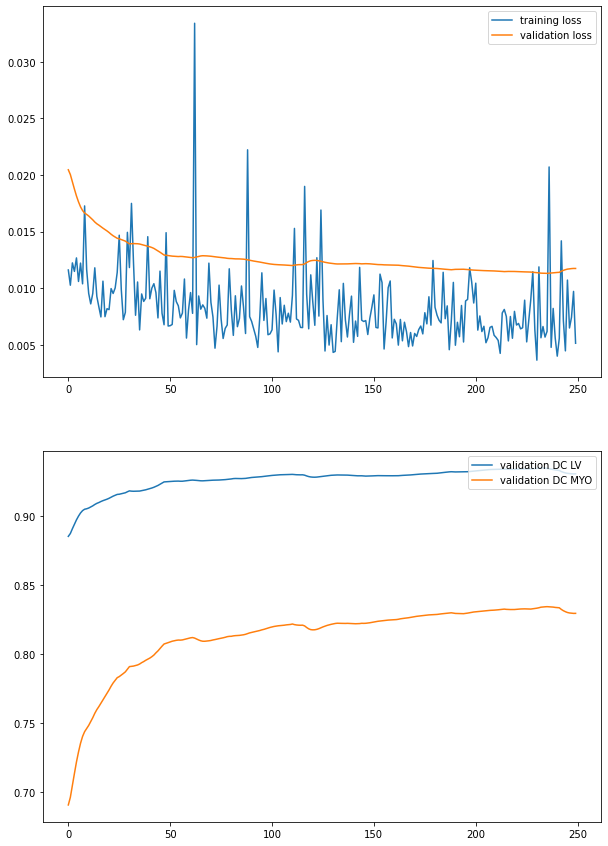

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,15))
ax1.plot(losses_train_epochs, label='training loss')
ax1.plot(losses_val_epochs, label='validation loss')
ax2.plot(dcs_lv_epochs, label='validation DC LV')
ax2.plot(dcs_myo_epochs, label='validation DC MYO')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')